<a href="https://colab.research.google.com/github/dauvannam321/CS114.M21.N02/blob/main/Toxic_Comment_Detection_On_Youtube_Football_Livestream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT PACKAGES

In [1]:
! pip install openpyxl
#Documentation : https://openpyxl.readthedocs.io/en/stable/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 511.7 MB 4.2 kB/s 
     |████████████████████████████████| 497.9 MB 18 kB/s 


In [3]:
!pip3 install  xlrd==1.2.0
!pip install --upgrade pandas
!pip install underthesea
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from pandas import Series, DataFrame
import xlrd
from sklearn.feature_extraction.text import TfidfVectorizer
from xlrd import open_workbook
from underthesea import word_tokenize #Documentation :https://pypi.org/project/underthesea/ 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 6.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.4 MB/s 
     |████████████████████████████████| 581 kB 37.7 MB/s 
     |████████████████████████████████| 965 kB 36.3 MB/s 
     |████████████████████████████████| 235 kB 31.5 MB/s 


# 1. Preprocess

In [4]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

In [5]:
dataTrainUIT = open_workbook("/content/dataset_main.xlsx", encoding_override='latin')
df = pd.read_excel(dataTrainUIT)


In [6]:
df.head()

,Content,Final
0,VN cố lên nha,0
1,90 phút nữa,0
2,các cầu thủ hãy cố gắng da hết mình nhé . nhất...,0
3,nhật ăn 3:0 r,0
4,1-0 cho vn,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Toxic Comment of Dataset')

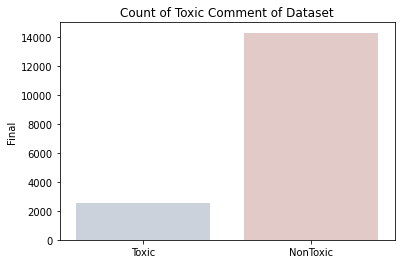

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(['Toxic', 'NonToxic'], df['Final'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset')

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = df['Content']
y = df['Final']
WordSeg = []
for i in range(len(X)):
        sentence_strip = str(X[i]).strip()# Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
X = pd.DataFrame(WordSeg) # Update new sentences
print(X)

                                                       0
0                                          VN cố lên nha
1                                            90 phút nữa
2      các cầu_thủ hãy cố_gắng da hết_mình nhé . nhất...
3                                        nhật ăn 3 : 0 r
4                                             1-0 cho vn
...                                                  ...
16798                                    đá vẫn chán lắm
16799                            vaooooooooooooooooooooo
16800                                           yeahhhhh
16801                     ghi_bàn rồi sẽ giải_toả tâm_lí
16802                      SUIIIIIIIIIIIIIIIIIIIIIIIIIII

[16803 rows x 1 columns]


In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
print(vectorized_text)

tf.Tensor(
[[   3   29   16 ...    0    0    0]
 [ 831  141   65 ...    0    0    0]
 [  64  142  584 ...    0    0    0]
 ...
 [4703    0    0 ...    0    0    0]
 [ 241    8  152 ...    0    0    0]
 [5847    0    0 ...    0    0    0]], shape=(16803, 50), dtype=int64)


In [15]:
X = vectorizer(X.values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Counter({0: 14291, 1: 2512})
Counter({0: 14291, 1: 14291})


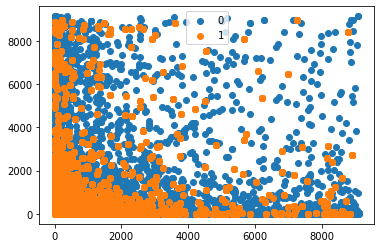

In [16]:
!pip install imbalanced-learn
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import imblearn
from imblearn.over_sampling import RandomOverSampler

# define dataset
counter = Counter(y)
print(counter)
# define the undersampling method
undersample =RandomOverSampler()

# transform the dataset
X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [17]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [18]:
train = dataset.take(int(len(dataset)*.6))#Train set 60%
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))#Valuating set 20%
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))#Test set 20%

# 2. Create Sequential Model

Mạng này sẽ nhận vào input là X và trả ra output Y : 
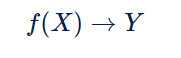

In [19]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

Sigmoid Function : 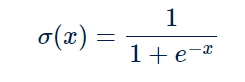

Hàm Sigmoid nhận đầu vào là một số thực và chuyển thành một giá trị trong khoảng (0;1) (xem đồ thị phía trên). Đầu vào là số thực âm rất nhỏ sẽ cho đầu ra tiệm cận với 0, ngược lại, nếu đầu vào là một số thực dương lớn sẽ cho đầu ra là một số tiệm cận với 1.

tanH Function : 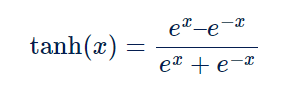

Hàm  nhận đầu vào là một số thực và chuyển thành một giá trị trong khoảng (-1; 1). Cũng như Sigmoid, hàm Tanh bị bão hoà ở 2 đầu (gradient thay đổi rất ít ở 2 đầu).

reLU Function : 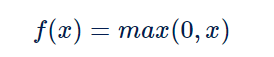

 ReLU đơn giản lọc các giá trị < 0.



In [20]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

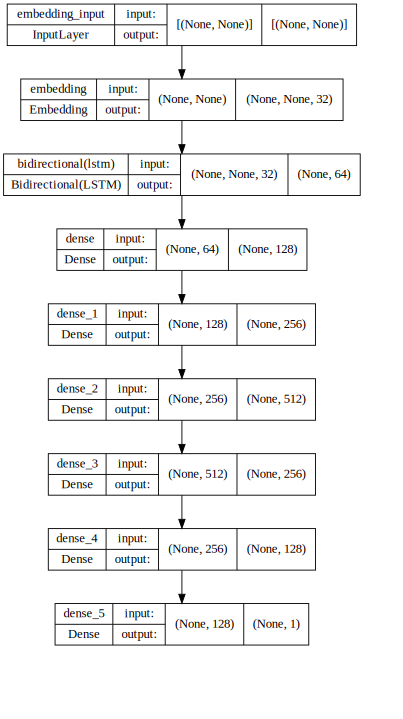

In [21]:
import keras
%matplotlib inline 

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model.png')

# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True,dpi=65).create(prog='dot', format='svg'))

Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.

Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
Về mặt toán học, nếu như MSE tính khoảng cách giữa 2 đại lượng số thì cross-entropy hiểu nôm na là phương pháp tính khoảng cách giữa 2 phân bố xác suất.
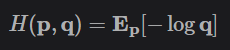

Với p và q là rời rạc (như y - nhãn thật sự và y^ - nhãn dự đoán ) trong bài toán của chúng ta), công thức này được viết dưới dạng:

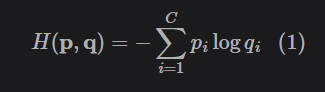

Trong đó C là số lượng các class cần phân lớp, trong bài toán binary classification thì C = 2.

Hàm mất mát: Binary Cross Entropy tính toán độ chênh lệch giữa 2 phân phối xác suất của dự đoán và của nhãn. Đầu ra của mô hình là phân phối xác suất (p, 1 - p) biểu diễn xác suất xảy ra của một trong hai nhãn. Phân phối xác suất của nhãn có dạng (y, 1 - y) với y nhận giá trị 0 hoặc 1.

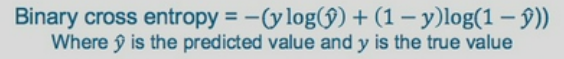

In [22]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                        

In [24]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
1072/1072 [==============================] - 142s 127ms/step - loss: 0.2794 - val_loss: 0.1325
Epoch 2/15
1072/1072 [==============================] - 126s 118ms/step - loss: 0.1222 - val_loss: 0.0793
Epoch 3/15
1072/1072 [==============================] - 120s 112ms/step - loss: 0.0789 - val_loss: 0.0578
Epoch 4/15
1072/1072 [==============================] - 124s 116ms/step - loss: 0.0614 - val_loss: 0.0652
Epoch 5/15
1072/1072 [==============================] - 117s 109ms/step - loss: 0.0572 - val_loss: 0.0423
Epoch 6/15
1072/1072 [==============================] - 130s 121ms/step - loss: 0.0467 - val_loss: 0.0445
Epoch 7/15
1072/1072 [==============================] - 118s 110ms/step - loss: 0.0441 - val_loss: 0.0332
Epoch 8/15
1072/1072 [==============================] - 121s 113ms/step - loss: 0.0380 - val_loss: 0.0344
Epoch 9/15
1072/1072 [==============================] - 118s 110ms/step - loss: 0.0379 - val_loss: 0.0338
Epoch 10/15
1072/1072 [=======================

In [25]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

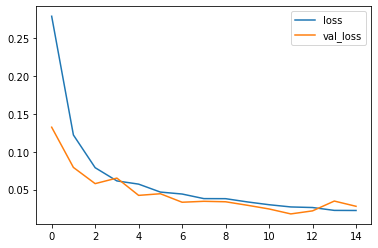

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [27]:
input_text = vectorizer(['tụi m giỏi thì vào mà đá, ở đó mà sủa ngu'])

In [28]:
print(input_text)

tf.Tensor(
[[295 117 247  14  17  11   2 149 122  11 849 112   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [29]:
res = model.predict(input_text)

In [30]:
print(res)

[[0.6747683]]


In [31]:
(res > 0.5).astype(int)

array([[1]])

In [32]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [33]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [34]:
res.shape

(1, 1)

In [35]:
input_text = vectorizer(['Việt Nam vô địch <3'])

In [36]:
print(input_text)

tf.Tensor(
[[  38   34  102 1152   60    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


In [37]:
res = model.predict(input_text)

In [38]:
print(res)

[[0.00268075]]


In [39]:
(res > 0.5).astype(int)

array([[0]])

In [40]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [41]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

In [42]:
res.shape

(1, 1)

In [43]:
input_text = vectorizer(['Việt Nam vô địt'])

In [44]:
print(input_text)

tf.Tensor(
[[ 38  34 102 694   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [45]:
res = model.predict(input_text)

In [46]:
print(res)

[[0.998472]]


In [47]:
(res > 0.5).astype(int)

array([[1]])

In [48]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [49]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [50]:
res.shape

(1, 1)

In [51]:
input_text = vectorizer(['chửi chết nó đi anh em'])

In [52]:
print(input_text)

tf.Tensor(
[[249 228  20  15  66 113   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [53]:
res = model.predict(input_text)

In [54]:
print(res)

[[0.90324986]]


In [55]:
(res > 0.5).astype(int)

array([[1]])

In [56]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [57]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [58]:
res.shape

(1, 1)


# 4. Evaluate Model

In [59]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [60]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [61]:
for batch in test.as_numpy_iterator(): 
  X_true, y_true = batch
  print("1 Comment trong 1 batch sau khi được vector hóa:")
  print(X_true[0])

  print("Nhãn của các comment trong batch:")
  print(y_true[0])

  print("Kết quả mà model predict được:")
  yhat = model.predict(X_true)
  print(yhat[0])
  break

1 Comment trong 1 batch sau khi được vector hóa:
[   4    8    2 7103   65    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Nhãn của các comment trong batch:
0
Kết quả mà model predict được:
[1.6563064e-13]


In [62]:
label = []
predict = []

for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    # print(batch)
    # print(len(batch[0]))
    X_true, y_true = batch
    # Make a prediction 
    # print(X_true)
    # print("Label: \n", y_true)
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    # print("Predict:\n", y_true)
    yhat = yhat.flatten()
    # print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    for i in y_true:
      label.append(i)
    for i in yhat:
      if i > 0.5:
        predict.append(1)
      else:
        predict.append(0)

In [63]:
# Nhãn ban đầu của tập test
print(label)

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 

In [64]:
# Kết quả mà mô hình dự đoán được
print(predict)

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 

In [65]:
toxic_in_test = 0
non_toxic_in_test = 0
toxic_predicted = 0
non_toxic_predicted = 0
for i in range(0,len(label)):
  if label[i] == 1:
    toxic_in_test+=1
  if label[i] == 0:
    non_toxic_in_test+=1
  if predict[i] == 1:
    toxic_predicted +=1
  if predict[i] == 0:
    non_toxic_predicted+=1

In [66]:
count = 0
for i in range(0,len(label)):
  if label[i] == predict[i]:
    count+=1

In [67]:
print("Số nhãn toxic trên tập test: ", toxic_in_test)
print("Số nhãn non-toxic trên tập test:",non_toxic_in_test)
print("Số nhãn predict toxic trên tập test: ",toxic_predicted)
print("Số nhãn predict non-toxic trên tập test: ",non_toxic_predicted)

Số nhãn toxic trên tập test:  2834
Số nhãn non-toxic trên tập test: 2878
Số nhãn predict toxic trên tập test:  2859
Số nhãn predict non-toxic trên tập test:  2853


In [68]:
"""from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))"""
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, F1 Score: {2*pre.result().numpy()*re.result().numpy()/(pre.result().numpy()+re.result().numpy())}, Accuracy:{count/len(label)}')

Precision: 0.9853095412254333, Recall:0.9940013885498047, F1 Score: 0.989636350613399, Accuracy:0.989670868347339


#5.Save and load model


In [69]:
model.save('tcd')

INFO:tensorflow:Assets written to: tcd/assets


INFO:tensorflow:Assets written to: tcd/assets


In [70]:
del model

In [71]:
model=load_model('tcd')

In [72]:
input_text = vectorizer([input()])

VN vô địch


In [73]:
print(input_text)

tf.Tensor(
[[   3  102 1152    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)


In [74]:
if((model.predict(input_text)>0.5).astype(int) == 1 ): print('Toxic') 
else :print('NonToxic')

NonToxic
